# Introduction
This python notebook will be used for testing out the NZN parameter sets

## Importing functions and parameter sets

In [18]:
from besos.parameters import wwr, RangeParameter, FieldSelector, FilterSelector, GenericSelector, Parameter, expand_plist
from besos.parameters import RangeParameter, CategoryParameter, expand_plist

from besos import eppy_funcs as ef
import besos.sampling as sampling
from besos.evaluator import EvaluatorEP
from besos.problem import EPProblem

import copy
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
import sys
import os
sys.path.insert(0,'../parameter_set/')

In [19]:
from architectural_parameters import architectural_parameters
from comfort_parameters import comfort_parameters
from envelope_parameters import envelope_parameters
from lighting_parameters import lighting_parameters
from loads_parameters import loads_parameters
from system_parameters import system_parameters
from system_parameters import FCU_parameters
from system_parameters import VAV_parameters
from system_parameters import CB_parameters
from plant_parameters import heating_plant_parameters
from plant_parameters import cooling_plant_parameters
from renewable_parameters import renewable_parameters

In [20]:
parameters=[]
defaults={}
metadata=[]

parameter_sets=[architectural_parameters,comfort_parameters,envelope_parameters,lighting_parameters,loads_parameters,system_parameters,FCU_parameters,VAV_parameters,
               CB_parameters,heating_plant_parameters,cooling_plant_parameters,renewable_parameters]

for i in parameter_sets:
    parameters.extend(i()[0])
    defaults.update(i()[1])
    metadata.extend(i()[2])

# Parametric Problem

## Outputs
We need to define which outputs we'll be using to analyze the parameter sets

In [21]:
import NZN_Office_output_set
from NZN_Office_output_set import fuel_use
from NZN_Office_output_set import end_use_breakdown
from NZN_Office_output_set import metrics

In [22]:
outputs = fuel_use()
outputs.extend(end_use_breakdown())
outputs.extend(metrics())

In [23]:
#Drop any meters that don't currently exist in E+
# outputs.remove('ExteriorLights:Electricity')
outputs.remove('InteriorEquipment:Gas')
outputs.remove('ExteriorEquipment:Electricity')
# outputs.remove('ExteriorEquipment:Gas')
# outputs.remove('WaterSystems:Electricity')
outputs.remove('Humidifier:Gas')

## Problem Formation
This ties everything together into one problem set

In [24]:
epw_victoria='CAN_BC_VictoriaUniversityCS_offset_from_Victoria-Univ.of.Victoria.717830_CWEC2016.epw'
problem = EPProblem(parameters,outputs)
num_runs=10
outdir='outputs'
inputs = sampling.dist_sampler(sampling.lhs, problem, num_runs)

building = ef.get_building('../NZN_Medium_Office_Default.idf',data_dict='../Energy+.idd')
evaluator = EvaluatorEP(problem, building, epw = epw_victoria, out_dir=outdir, error_mode='Silent',error_value=None)

In [25]:
# load results
results = pd.read_csv('./CC_job/results.csv', index_col='Unnamed: 0')
outputs_d = results[outputs]
inputs_d = results.iloc[:,:len(parameters)]

## Unit Conversion
The basic units used in the E+ meters are joules per year. We want to convert this to ekWh/m2.

In [26]:
# floor_area=ef.read_sql(path=output_path,cmds=['floor area'])['floor area']
floor_area=4980

In [27]:
#Function to do conversion
def J_to_ekwh_eui(energy_J, floor_area):
    energy_GJ=energy_J/1000000000
    energy_kwh=energy_GJ*277.8
    EUI=energy_kwh/floor_area
    return EUI

In [28]:
results_EUI=J_to_ekwh_eui(outputs_d,floor_area)
# results_EUI.max()

In [29]:
#Filter any error'd simulation runs
results_EUI = inputs_d.join(results_EUI).replace([np.inf, -np.inf], np.nan).dropna().loc[:,results_EUI.columns]

inputs = inputs_d.join(results_EUI).replace([np.inf, -np.inf], np.nan).dropna().loc[:,inputs_d.columns]

In [30]:
results_EUI.replace([np.inf, -np.inf], np.nan)

Electricity:Facility  Gas:Facility  DistrictHeating:Facility  \
0                22.517281     40.409712                  0.000000   
1                47.053625     17.774877                  0.000000   
2                11.556814      3.129882                  0.000000   
3                22.568118     27.267848                  0.000000   
4                19.210506     21.312521                  0.000000   
...                    ...           ...                       ...   
9875             37.450904      7.108208                  0.000000   
9876             21.040165     22.678590                  0.000185   
9877             33.785653      8.196050                  0.000000   
9878             24.008409     40.784611                  0.000000   
9879             31.181604      6.328190                  0.000000   

      DistrictCooling:Facility  Heating:Electricity  Heating:Gas  \
0                     0.000000             0.000000    33.602050   
1                     0.018327             0.000000    12.245736   
2                     0.000000             1.972781     1.806396   
3                     0.000000             0.000000    22.796329   
4                     0.000000             0.000000    20.768413   
...                        ...                  ...          ...   
9875                  0.008931             4.246206     0.000000   
9876                  0.008999             0.000000    17.193456   
9877                  0.000000             1.659457     2.359702   
9878                  0.000000             0.000000    33.576227   
9879                  0.818510             0.000000     3.506680   

      Heating:DistrictHeating  Cooling:Electricity  Cooling:DistrictCooling  \
0                    0.000000             1.480717                 0.000000   
1                    0.000000             4.706777                 0.018327   
2                    0.000000             0.465105                 0.000000   
3                    0.000000             1.193894                 0.000000   
4                    0.000000             0.598547                 0.000000   
...                       ...                  ...                      ...   
9875                 0.000000             4.344351                 0.008931   
9876                 0.000185             3.204839                 0.008999   
9877                 0.000000             3.221854                 0.000000   
9878                 0.000000             1.293320                 0.000000   
9879                 0.000000             3.551146                 0.818510   

      InteriorLights:Electricity  ExteriorLights:Electricity  \
0                       3.184673                    2.481657   
1                       8.365429                    8.408115   
2                       3.183020                    0.214552   
3                       5.279541                    3.815264   
4                       4.235543                    7.445235   
...                          ...                         ...   
9875                    2.121367                   10.646799   
9876                    0.803221                    7.967223   
9877                    4.261728                    8.769624   
9878                    2.565752                    1.567292   
9879                    2.214025                    9.754661   

      InteriorEquipment:Electricity  ExteriorEquipment:Gas  Fans:Electricity  \
0                          5.908558               6.733386          4.435556   
1                         11.954267               5.529141          4.429561   
2                          4.074590               1.184202          0.324319   
3                          5.833445               4.431951          2.890328   
4                          3.212217               0.544109          2.307309   
...                             ...                    ...               ...   
9875                      11.323385               6.912703          3.

In [26]:
#Lets pickle these to store for later

inputs.to_pickle('overall_inputs_large_run3.p')
results_EUI.to_pickle('overall_results_large_run3.p')

# Surrogate Model

In [23]:
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LeakyReLU


Couldn't import dot_parser, loading of dot files will not be possible.


In [24]:
inputs = pd.read_pickle('overall_inputs_large.p')
results_EUI = pd.read_pickle('overall_results_large.p')

## One Hot Encoding
We need to convert our categorical values in one-hot encoded columns for non-ordinal ML training.

In [31]:
inputs_onehot=pd.get_dummies(inputs)

## Train-Test Split
We'll do 80/20 train/test split here

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
train_in, test_in, train_out, test_out = train_test_split(inputs_onehot, results_EUI, test_size=0.2)

## Normalization of inputs/outputs

In [39]:
scaler_in = StandardScaler()
NN_inputs = scaler_in.fit_transform(X=train_in)
NN_inputs_test=scaler_in.transform(X=test_in)

scaler_out = StandardScaler()#PowerTransformer(method='box-cox')
NN_outputs = scaler_out.fit_transform(X=train_out+0.00001)
NN_outputs_test=scaler_out.transform(X=test_out+0.00001)

## Build the Model
Using the keras functional API, we will build a relatively simple deep neural network

In [40]:
#This matches the number of parameter inputs we have to enter as the input layer into the NN
num_inputs = len(inputs_onehot.columns)
print(f'Number of inputs: {num_inputs}')
#This matches the number of model outputs we have to enter as the output layer into the NN
num_outputs = len(results_EUI.columns)
print(f'Number of inputs: {num_outputs}')

Number of inputs: 98
Number of inputs: 21


In [253]:
#Create a 4-layer model, with 2 middle layers both with nodes that are 16*the number of inputs
#The hidden layers are activated with ReLU function.
# Since we are performing regression we do not want an activation for the output. 
#The output has been normalized to 0 +/- 1 std, and a ReLU activation function only returns positive numbers.
#We will use an L2 regularizer to help prevent overfitting. For now we will use the default alpha 0.01.

input_layer = keras.Input(shape=(num_inputs,))

#first hidden layer
dense_1 = layers.Dense(units=num_inputs*5, kernel_regularizer='l2')(input_layer)
activation_1=layers.LeakyReLU()(dense_1)
#second hidden layer
dense_2 = layers.Dense(units=num_inputs*5, kernel_regularizer='l2')(activation_1)
activation_2=layers.LeakyReLU()(dense_2)
#third hidden layer
dense_3 = layers.Dense(units=num_inputs*5, kernel_regularizer='l2')(activation_2)
activation_3=layers.LeakyReLU()(dense_3)


#output layer
output_layer = layers.Dense(units=num_outputs)(activation_3)

model=models.Model(inputs=input_layer,outputs=output_layer)

In [254]:
print(model.summary())
# plot_model(model)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 98)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 490)               48510     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 490)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 490)               240590    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 490)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 490)               240590    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 490)               0   

## Hyper-parameters

Before we start fitting the NN model we define the set of hyperparameters we want to analyse in our cross-validation to optimize the model.  
Here, we select the number of layers of the network as well as the regularization parameter alpha as parameter value.  
A larger number of layers and a lower value of the regularizer lead to higher variance of the network.  
This may lead to overfitting.  
The best selection may be found using an optimizer like Bayesian Optimization.  
In this example we use a simple grid search.

## Training

Here we will compile and train the model.

In [255]:
loss = 'mean_squared_error'
optimizer = 'adam'
metrics=['mae', 'mse']

model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

In [273]:
history=model.fit( x=NN_inputs, y=NN_outputs, batch_size = 256,epochs=1000)
test_scores = model.evaluate(NN_inputs_test, NN_outputs_test, verbose=2)
print("Test MAE:", test_scores[0])
print("Test MSE:", test_scores[1])

Epoch 1/1000
28/28 [==============================] - 0s 6ms/step - loss: 0.2691 - mae: 0.1721 - mse: 0.1901
Epoch 2/1000
28/28 [==============================] - 0s 6ms/step - loss: 0.2705 - mae: 0.1716 - mse: 0.1917
Epoch 3/1000
28/28 [==============================] - 0s 5ms/step - loss: 0.2732 - mae: 0.1766 - mse: 0.1928
Epoch 4/1000
28/28 [==============================] - 0s 6ms/step - loss: 0.2704 - mae: 0.1715 - mse: 0.1907
Epoch 5/1000
28/28 [==============================] - 0s 5ms/step - loss: 0.2688 - mae: 0.1723 - mse: 0.1899
Epoch 6/1000
28/28 [==============================] - 0s 6ms/step - loss: 0.2701 - mae: 0.1716 - mse: 0.1907
Epoch 7/1000
28/28 [==============================] - 0s 6ms/step - loss: 0.2721 - mae: 0.1746 - mse: 0.1920
Epoch 8/1000
28/28 [==============================] - 0s 6ms/step - loss: 0.2739 - mae: 0.1759 - mse: 0.1930
Epoch 9/1000
28/28 [==============================] - 0s 5ms/step - loss: 0.2728 - mae: 0.1753 - mse: 0.1931
Epoch 10/1000
28/28

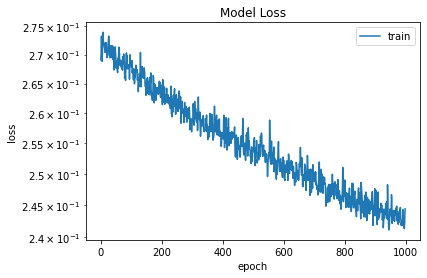

In [274]:
fig = plt.figure()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

## Run large grid search

## Evaluate test set
Evaluate the test set using the NN and the actual values

In [275]:
train_eval=model.predict(NN_inputs)

In [276]:
train_eval=scaler_out.inverse_transform(train_eval)

In [277]:
train_eval_df=pd.DataFrame(train_eval,columns=results_EUI.columns)

In [278]:
test_eval=model.predict(NN_inputs_test)
test_eval=scaler_out.inverse_transform(test_eval)
test_eval_df=pd.DataFrame(test_eval,columns=results_EUI.columns)

In [279]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

In [280]:
mask = test_eval_df.isnull().values.sum(axis=1)==1
print(mask.sum())

0


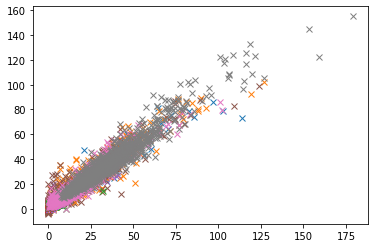

In [281]:
_=[plt.plot(test_out.iloc[:,i], test_eval_df.iloc[:,i],'x') for i in range(num_outputs)]
print()

[ 0.9225306   0.90779811 -0.00590128  0.45177574  0.90709713  0.90188546
 -0.00574744  0.66301921  0.45184729  0.9378147   0.9898007   0.89223202
  0.73973736  0.40984258  0.93711221  0.9944066   0.89931894  0.91850701]



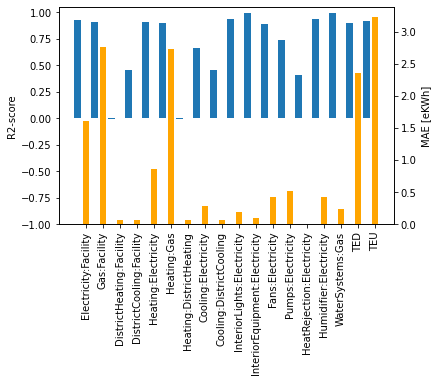

In [282]:
plt.bar(range(0,len(outputs)*2,2),r2_score(test_out.values[:,:], test_eval_df.values[:,:], multioutput='raw_values'))
plt.ylim([-1,1.05])
ax = plt.gca()
ax2=ax.twinx()

ax2.bar(range(1,len(outputs)*2,2),
        mean_absolute_error(test_out.values[:,:], test_eval_df.values[:,:], multioutput='raw_values'),
       color='orange')

ax.set_xticks(range(1,len(outputs)*2,2))
_=ax.set_xticklabels(outputs, rotation=90)
ax.set_ylabel('R2-score')
ax2.set_ylabel('MAE [eKWh]')
plt.grid=False
print(r2_score(test_out.values[:,:], test_eval_df.values[:,:], multioutput='raw_values'))
print()

# Train one surrogate per output

In [284]:
def build_model(num_outputs=1):
    input_layer = keras.Input(shape=(num_inputs,))

    #first hidden layer
    dense_1 = layers.Dense(units=num_inputs*4, kernel_regularizer='l2')(input_layer)
    activation_1=layers.LeakyReLU()(dense_1)
    #second hidden layer
    dense_2 = layers.Dense(units=num_inputs*4, kernel_regularizer='l2')(activation_1)
    activation_2=layers.LeakyReLU()(dense_2)
    #third hidden layer
    dense_3 = layers.Dense(units=num_inputs*4, kernel_regularizer='l2')(activation_2)
    activation_3=layers.LeakyReLU()(dense_3)


    #output layer
    output_layer = layers.Dense(units=num_outputs)(activation_3)

    model = models.Model(inputs=input_layer,outputs=output_layer)
    return model

In [331]:
scores = []
for n,out in enumerate(outputs):
    model = build_model()
    model.compile(loss=loss,optimizer=optimizer,metrics=metrics)
    scaler_out = MinMaxScaler()#PowerTransformer(method='box-cox')
    NN_outputs = scaler_out.fit_transform(X=train_out.iloc[:,n].values.reshape(-1,1))
    NN_outputs_test=scaler_out.transform(X=test_out.iloc[:,n].values.reshape(-1,1))
    
    history=model.fit(x=NN_inputs, y=NN_outputs, batch_size = 256,epochs=1000, verbose=0)
    test_eval=model.predict(NN_inputs_test)
    test_eval=scaler_out.inverse_transform(test_eval.reshape(-1,1))
    test_eval_df=pd.DataFrame(test_eval,columns=[results_EUI.columns[n]])
    
    scores.append(r2_score(test_out.loc[:,out], test_eval_df))

[ 8.0113318e-01  8.2694388e-01 -8.1810000e-04 -4.1527000e-04
  7.7196622e-01  8.2904137e-01 -2.9380600e-03 -1.6000000e-06
 -1.5668100e-03  9.0568517e-01  9.9161920e-01 -2.2000000e-07
 -1.0670000e-04 -1.1339200e-03  8.9114620e-01  9.9701481e-01
  7.2726780e-01  6.9999275e-01]


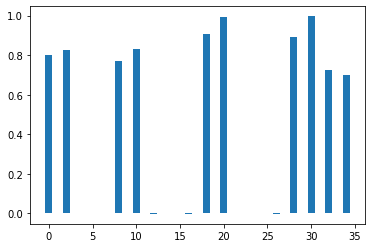

In [332]:
plt.bar(range(0,len(outputs)*2,2),scores)
print(np.array(scores).round(8))

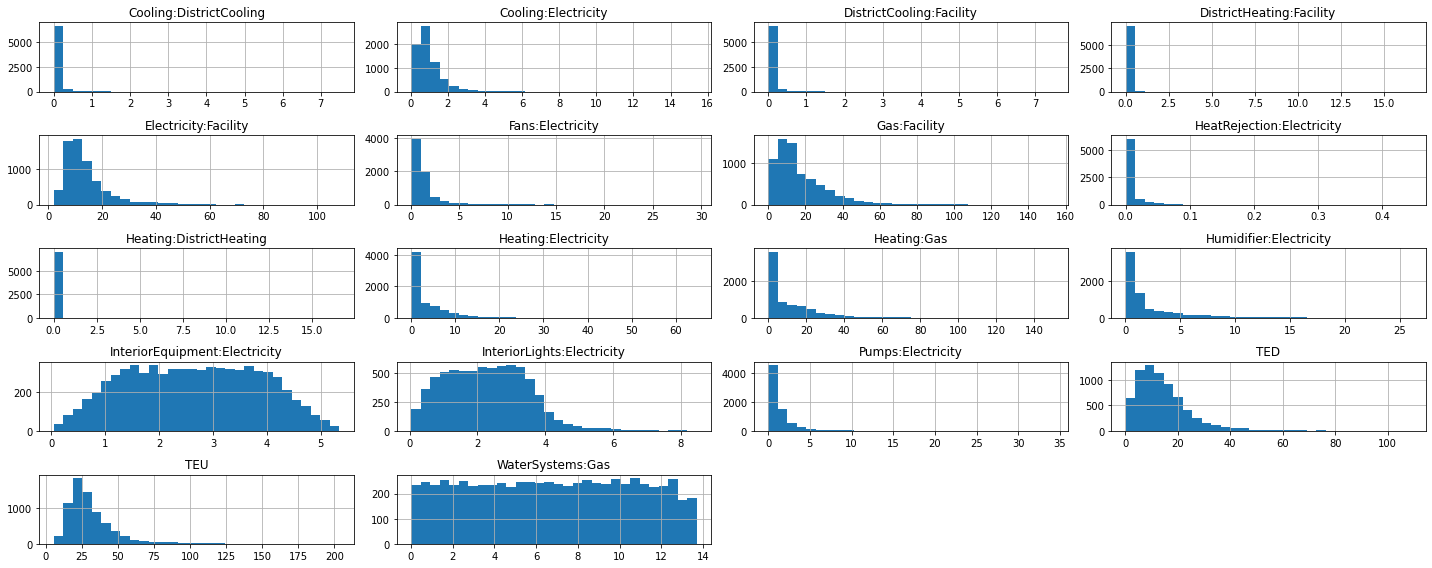

In [326]:
_=train_out.hist(figsize=(20,8), bins=30)
plt.tight_layout()

In [333]:
scores_old - scores

TypeError: unsupported operand type(s) for -: 'list' and 'list'

# Store Model

In [41]:
# pickle the model:
import pickle
pickle.dump([inputs_onehot.columns, metadata, results_EUI.columns, scaler_in, scaler_out, inputs_onehot, results_EUI], open('model_pickle','wb'))